# Airbnb Project

## Set up data

To start with, it is very important to define what "active the last 12 months" listing is. Each listings.csv has information for the last 12 months of the listings that are active at a snapshot of the current quarter of the year. So, we can define as active all the listings that were active at some point of the year. As a consequence, <span style="color: orange;">active listngs for the last 12 months consist of all the **unique** listings for all the CSV files available</span>.

* First, we need to download and import the necessary libraries

In [1]:
%pip install pandas matplotlib altair ipywidgets beautifulsoup4 requests selenium webdriver-manager scikit-learn numpy

import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import io
import altair as alt
from IPython.display import display, clear_output
import ipywidgets as widgets
from bs4 import BeautifulSoup
import requests
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import datetime
from sklearn.impute import SimpleImputer
import numpy as np


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\karyo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


* To download the resources we will use beautifulsoup to retrieve the csv links and selenium so we can click the `show` button. **If chrome is not installed at the device, a different browser Driver Manager should be used e.g. webdriver.Safari()**. <span style="color: cyan">Dont forget to update the imports about driver manager accordingly </span>.
* We will need listings and reviews data.

In [2]:

cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'copenhagen', 'dublin', 'lisbon', 'london', 'madrid', 'paris', 'rome', 'venice', 'vienna']
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

try:
    driver.get("https://insideairbnb.com/get-the-data/")
    WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.showArchivedData")))
    
    show_links = driver.find_elements(By.CSS_SELECTOR, "a.showArchivedData")
    for show_link in show_links:
        try:
            # Scroll to the show button  and click it
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", show_link)
            WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a.showArchivedData")))
            driver.execute_script("arguments[0].click();", show_link)
            time.sleep(0.5)  # Small delay to allow new content to load
            
        except Exception as e:
            print(f"Failed to click a link: {e}")
    
    # Give time for all CSV links to load after clicks
    time.sleep(0.5)
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    #Ensure that the CSV links are only for the cities we are interested in and are files for the visualizations
    csv_links = list(set(link['href'] for link in soup.find_all("a", href=True) 
                        if (link['href'].endswith("/visualisations/listings.csv") or 
                            link['href'].endswith("/visualisations/reviews.csv"))and
                            any(city in link['href'] for city in cities)))
    print(f"Found {len(csv_links)} CSV links")
    
    # Ensure download directory exists
    os.makedirs("airbnb_data", exist_ok=True)

    # Download each CSV file if not already downloaded
    for url in csv_links:
        if "listings.csv" in url:
            filename = f"airbnb_data/{url.split('/')[-4]}/{url.split('/')[-3]}_listings.csv"
        elif "reviews.csv" in url:
            filename = f"review_data/{url.split('/')[-4]}/{url.split('/')[-3]}_reviews.csv"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        if not os.path.exists(filename):
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    with open(filename, "wb") as f:
                        f.write(response.content)
                    print(f"Downloaded {filename}")
                else:
                    print(f"Failed to download {url}: HTTP {response.status_code}")
            except Exception as e:
                print(f"Failed to download {url}: {e}")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    driver.quit()

Found 102 CSV links


* To process our data easier, it is better to work with one dataframe. So, we add a city column to each city's dataframe about listings and also create a "quarter" column so we can keep the newest version when duplicates exist. Then, we can concatenate all the dataframes into one.

In [3]:
city_dfs = {}
for city in cities:
    city = city.capitalize()
    city_folder = f"airbnb_data\{city}"
    city_dfs[city] = []

    files_with_dates = []

    for filename in os.listdir(city_folder):
        if filename.endswith("_listings.csv"):  
            filepath = os.path.join(city_folder, filename)
            date_str = filename.split('_')[0]
            date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
            files_with_dates.append((filename, date))
    
    # Sort the files by date (newest first)
    files_with_dates.sort(key=lambda x: x[1], reverse=True)
    
    # Loop through the sorted files and assign quarters
    for idx, (filename, _) in enumerate(files_with_dates):
        # Determine the quarter: Q4 for the newest, Q3 for the next, etc.
        quarter = f"Q{4 - idx}"
        filepath = os.path.join(city_folder, filename)
        try:
            df = pd.read_csv(filepath)
            df['quarter'] = quarter
            df['city'] = city
            city_dfs[city].append(df)
        except Exception as e:
            print(f"Failed to read {filepath}: {e}")
    # Concatenate all DataFrames for this city into one large DataFrame
    if city_dfs[city]:
        city_dfs[city] = pd.concat(city_dfs[city], ignore_index=True)
    else:
        print(f"No data found for {city}")

* Then we do the same about the reviews.

In [4]:
review_dfs = {}
for city in cities:
    review_folder = f"review_data\{city}"
    city = city.capitalize()
    review_dfs[city] = []

    files_with_dates = []

    for filename in os.listdir(review_folder):
        if filename.endswith("_reviews.csv"):  
            filepath = os.path.join(review_folder, filename)
            date_str = filename.split('_')[0]
            date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
            files_with_dates.append((filename, date))
    
    # Sort the files by date (newest first)
    files_with_dates.sort(key=lambda x: x[1], reverse=True)
    
    # Loop through the sorted files and assign quarters
    for idx, (filename, _) in enumerate(files_with_dates):
        # Determine the quarter: Q4 for the newest, Q3 for the next, etc.
        quarter = f"Q{4 - idx}"
        filepath = os.path.join(review_folder, filename)
        try:
            df = pd.read_csv(filepath)
            df['quarter'] = quarter
            df['city'] = city
            review_dfs[city].append(df)
        except Exception as e:
            print(f"Failed to read {filepath}: {e}")
    # Concatenate all DataFrames for this city into one large DataFrame
    if review_dfs[city]:
        review_dfs[city] = pd.concat(review_dfs[city], ignore_index=True)
    else:
        print(f"No data found for {city}")


* We have to keep unique reviews for each listing, as each new reviews.csv file contains the previous files reviews as well as new. For example, **a csv from December 2023 may contain at the `reviews_ltm` column a number of reviews that exceeds by more than half a year the threshold of last twelve months that we have in the assignment**. This proccess may take a few minutes:

In [5]:
unique_reviews = {}
quarter_order = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}

for city, df in review_dfs.items():
    city = city.capitalize()
    # Convert the 'quarter' column to a categorical type based on the custom order
    df['quarter'] = df['quarter'].map(quarter_order)
    
    # Sort by host_id and quarter (now mapped numerically), with the highest quarters first
    df_sorted = df.sort_values(by=['listing_id', 'quarter'], ascending=[True, False])
    latest_reviews_list = []

    # Create an empty DataFrame to collect unique records for the city
    unique_reviews_city = pd.DataFrame()
    
    # Group by each host_id to select records from the latest available quarter
    for host_id, group in df_sorted.groupby('listing_id'):
        # Get the maximum quarter (numeric) available for this host_id
        max_quarter = group['quarter'].max()
        
    # Select only the records in the latest quarter for this listing_id
        latest_reviews = group[group['quarter'] == max_quarter]
        
        # Add the filtered rows to the list
        latest_reviews_list.append(latest_reviews)
    
    # Convert quarter column back to its original string format
    unique_reviews_city = pd.concat(latest_reviews_list)
    
    # Save the city-specific DataFrame in the dictionary
    unique_reviews[city] = unique_reviews_city.reset_index(drop=True)


* It is convenient to concatenete all reviews dataframes into one and also keep reviews for the last 12 months, starting from 1st November 2023:

In [6]:
all_reviews = pd.concat(unique_reviews.values(), ignore_index=True)

# Convert the 'date' column to a datetime type so we can filter by date
all_reviews['date'] = pd.to_datetime(all_reviews['date'])

# Filter to only include reviews from after November 1, 2023
all_reviews_ltm = all_reviews.loc[all_reviews['date'] >= pd.Timestamp('2023-11-01')]

* Below we clean the data by removing duplicates. First, we must check if IDs are unique for each city. 

In [7]:
df_all_cities = pd.concat(city_dfs.values(), ignore_index=True)
is_id_per_city_unique = df_all_cities.groupby('id')['city'].nunique() == 1
non_unique_ids = is_id_per_city_unique[is_id_per_city_unique == False].index
non_unique_ids

Index([785248735399206901, 1112140400772078627], dtype='int64', name='id')

* As there are 2 id that are not unique between the cities we must drop duplicates taking into condideration city-id pairs. Sorting on 'quarter' is used as a second sorting key, so that the parameter keep='first' can work properly, removing all the non-first instances (duplicate reviews from previous quarter files).

In [8]:
df_all_cities = df_all_cities.sort_values(by=['id', 'quarter'], ascending=[True, False])
df_all_cities = df_all_cities.drop_duplicates(subset=['city','id'], keep='first')

# Airbnb Listings

* To find the number of listing we can just group by the column 'city'. Reset index parameter is optional in order to have integer indexes.

In [9]:
number_of_listings = df_all_cities.groupby('city').size().reset_index(name='number_of_listings')
number_of_listings

,city,number_of_listings
0,Amsterdam,11342
1,Athens,17112
2,Barcelona,24860
3,Berlin,15830
4,Copenhagen,24927
5,Dublin,12196
6,Lisbon,28914
7,London,129659
8,Madrid,35542
9,Paris,118804


We can visualize the output using matplotlib

<BarContainer object of 13 artists>

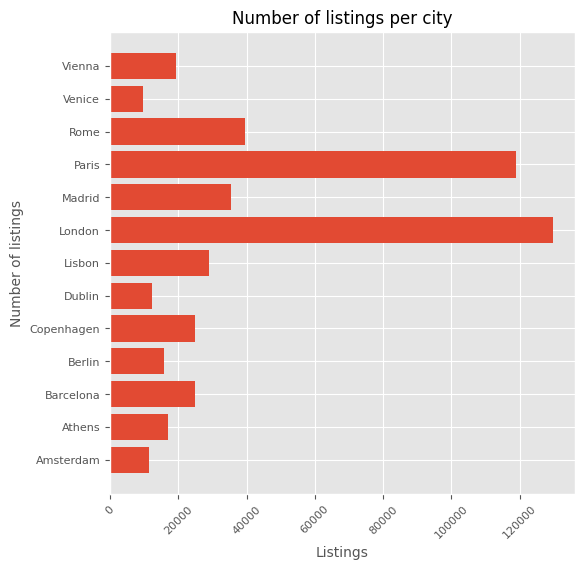

In [10]:
plt.figure(figsize=(6, 6))
plt.style.use('ggplot')
plt.title('Number of Listings per City', fontsize=12)
plt.xlabel('Listings',fontsize=10)
plt.ylabel('Number of listings',fontsize=10)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.title('Number of listings per city', fontsize=12)
plt.barh(number_of_listings['city'], number_of_listings['number_of_listings'])

# Airbnb Densities

To calculate the AirBnB densities the metric of listing per 1000 inhabitants is used. Thus, we need an appropriate method to calculate the populations, as presented at the outline of each city from the airbnb website.

To do that there are multiple ways:
* Use the most recent available data from the respective countries' statistics authorities or central statistics bureaus.
* Use geojson and datasets about population to create a mapping in a Geographic Information System (GIS).
* Use [geonames database](https://www.geonames.org).

For the scope of the assignment we will use the [*QGIS*](https://www.qgis.org) open-source tool, so that we can obtain very accurate data.
That is important becauses in some cases we should consider not using the whole population of the city. Instead we must consider the population as defined from [insideairbnb](https://insideairbnb.com) perimeter for the cities.
After downloading QGIS, we can compute the population doing the following steps for each city:
1. Load the `.geojson` file from https://insideairbnb.com/get-the-data/ with the listing datapoints
2. Load the `.tif` geotiff files that contain the population for the corresponding country https://hub.worldpop.org/geodata/listing?id=78
3. Convert both layers to the same CRS e.g. EPSG:4979
4. Use the *Zonal Statistics* tool to map the geojson to the .tif:
    * As raster layer use the .tiff file
    * As input layer use the .geojson file
5. Open layer's Attribute Table of the Zonal Statistics output
6. Click *Select features using an expression*
7. Type $round(sum("\_sum"),0)$ and the result is the population for the city



<table>
    <tr>
        <td><img src="italy.png" alt="Rome and Venice in GQIS" width="250" height="100">Rome and Venice</td>
        <td><img src="athens.png" alt="Athens in GQIS" width="250" height="100">Athens</td>
        <td><img src="dublin.png" alt="Dublin in GQIS" width="250" height="100">Dublin</td>
    </tr>
</table>

In [11]:
population = {
    "Amsterdam": 706305,
    "Athens": 635528,
    "Berlin": 3260215,
    "Barcelona": 1833132,
    "Madrid": 3722248,
    "Copenhagen": 774844,
    "Dublin": 1532646,
    "Lisbon": 2322783,
    "London": 9202151,
    "Venice": 239572,
    "Rome": 2682686,
    "Paris": 2370252,
    "Vienna": 1873789
}
population_df = pd.DataFrame(list(population.items()), columns=['city', 'population'])
population_df

,city,population
0,Amsterdam,706305
1,Athens,635528
2,Berlin,3260215
3,Barcelona,1833132
4,Madrid,3722248
5,Copenhagen,774844
6,Dublin,1532646
7,Lisbon,2322783
8,London,9202151
9,Venice,239572


* Our Dataset contains the population from 2020. As a consequence we need to take into consideration the growth rate of the population.
To calculate it without searching through national statistic offices, we can assume that the growth rate of the city is the same as the growth rate of the country (probably not true). Then, we can use a dataset from the [World Bank](https://data.worldbank.org/indicator/SP.POP.GROW).

In [12]:
zip_url = 'https://api.worldbank.org/v2/en/indicator/SP.POP.GROW?downloadformat=csv'
file_name_in_zip = 'API_SP.POP.GROW_DS2_en_csv_v2_10148.csv'
response = requests.get(zip_url)

if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open(file_name_in_zip) as f:
            growth_rate = pd.read_csv(f, skiprows=4)
growth_rate = growth_rate[['Country Name', '2021', '2022', '2023']]

* Now we need to map the growth rate of the countries to each city and multiply the population by the growth rate.

In [13]:
city_to_country = {
    "Amsterdam": "Netherlands",
    "Athens": "Greece",
    "Berlin": "Germany",
    "Barcelona": "Spain",
    "Madrid": "Spain",
    "Copenhagen": "Denmark",
    "Dublin": "Ireland",
    "Lisbon": "Portugal",
    "London": "United Kingdom",
    "Venice": "Italy",
    "Rome": "Italy",
    "Paris": "France",
    "Vienna": "Austria"
}
city_and_country = pd.DataFrame(list(city_to_country.items()), columns=['city', 'Country Name'])
growth_rate_with_city = pd.merge(growth_rate, city_and_country, on='Country Name')
growth_rate_with_city_and_population = growth_rate_with_city.merge(population_df, on='city')

* ``growth_rate`` dataframe contains population for 2020 and the population growth for the next years than can provide a good estimation.

In [14]:
growth_rate_with_city_and_population['final_population'] = growth_rate_with_city_and_population['population'] * \
    (1 + growth_rate_with_city_and_population['2021'] / 100) * (1 + growth_rate_with_city_and_population['2022'] / 100) * (1 + growth_rate_with_city_and_population['2023'] / 100)
growth_rate_with_city_and_population.drop(columns=['2021', '2022', '2023', 'Country Name', 'population'], inplace=True)
growth_rate_with_city_and_population['final_population'] = growth_rate_with_city_and_population['final_population'].astype(int)

* We need to merge the population dataframe with the listings dataframe to to find the density.

In [15]:

number_of_listings_and_population = pd.merge(number_of_listings[['city','number_of_listings']], growth_rate_with_city_and_population, on='city')
number_of_listings_and_population.rename(columns={'final_population': 'population'}, inplace=True)
number_of_listings_and_population[['city','population']]

,city,population
0,Amsterdam,723962
1,Athens,615375
2,Barcelona,1871933
3,Berlin,3311823
4,Copenhagen,790143
5,Dublin,1616918
6,Lisbon,2374059
7,London,9375282
8,Madrid,3801036
9,Paris,2391236


Now we just have to use $ density = (listings / population) * 1000 $

In [16]:
number_of_listings_and_population['number_of_listings_per_1000_inhabitants'] = (number_of_listings_and_population['number_of_listings']/number_of_listings_and_population['population'])*1000
number_of_listings_and_population['number_of_listings_per_1000_inhabitants'] = number_of_listings_and_population['number_of_listings_per_1000_inhabitants'].round(2)
number_of_listings_and_population[['city', 'number_of_listings_per_1000_inhabitants']].rename(columns={'number_of_listings_per_1000_inhabitants': 'Listings per 1000 inhabitants','city':'City'},inplace=False)


,City,Listings per 1000 inhabitants
0,Amsterdam,15.67
1,Athens,27.81
2,Barcelona,13.28
3,Berlin,4.78
4,Copenhagen,31.55
5,Dublin,7.54
6,Lisbon,12.18
7,London,13.83
8,Madrid,9.35
9,Paris,49.68


Once again, we we visualize the output using matplotlib.

<BarContainer object of 13 artists>

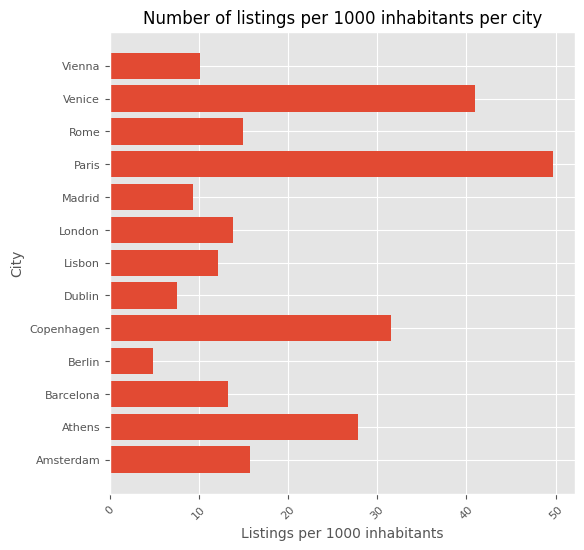

In [17]:
plt.figure(figsize=(6, 6))
plt.title('Number of listings per 1000 inhabitants per city', fontsize=12)
plt.xlabel('Listings per 1000 inhabitants',fontsize=10)
plt.ylabel('City',fontsize=10)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.style.use('ggplot')
plt.barh(number_of_listings_and_population['city'], number_of_listings_and_population['number_of_listings_per_1000_inhabitants'])

# Activity

* To calculate the average number of nights a listing is booked, we assume that half of the bookings have reviews and that each booking is for three nights. For each listing we use the dataframe containing the reviews of the last 12 months.

* We can see that there are many listings with an irregular number of reviews.

In [18]:
all_reviews_ltm.groupby(['city','listing_id']).size().reset_index(name='number_of_reviews').nlargest(10, 'number_of_reviews')

,city,listing_id,number_of_reviews
23688,Barcelona,52981104,1033
26188,Barcelona,846093318788581404,806
242546,Venice,37706095,752
3050,Amsterdam,50383849,734
163512,Paris,17222007,725
2145,Amsterdam,32485135,701
2815,Amsterdam,45045046,628
256632,Vienna,1100481835389224680,550
41918,Copenhagen,44470634,545
221175,Rome,35636293,521


* It is a good idea that we filter these, to receive a cleaned number of reviews.  
Our assumption is that $nights = reviews * 6$, so by appyling a threshold we can have a better view.

* Setting the limit to 61 makes sense because by multiplying by 6 with a number bigger than that, it would result to more than 365 booked nights for the year.

In [19]:
review_counts = all_reviews_ltm.groupby(['city','listing_id']).size().reset_index(name='number_of_reviews')
review_counts['number_of_reviews'] = review_counts['number_of_reviews'].apply(lambda x: x if x < 61 else 61)

In [20]:
stays_per_city = review_counts
stays_per_city['stays'] = review_counts['number_of_reviews'] * 6

In [21]:
# Loop over each city and impute the 'price' column separately within each group
for city, city_df in df_all_cities.groupby('city'):
    # Initialize the imputer for each city's subset
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
    imputed_prices = imputer.fit_transform(city_df[['price']])
    df_all_cities.loc[city_df.index, 'price'] = imputed_prices

* To calculate the revenue for each listing we can use: $$revenue = stays * price$$

In [22]:
prices = pd.merge(stays_per_city, df_all_cities[['price','id']], left_on='listing_id', right_on='id',how='inner')
prices['revenue'] = prices['price'] * prices['stays']
revenue = prices.groupby('city')['revenue'].mean().reset_index(name='average_revenue')

* We need to adjust Copenhagen and London revenue because they do not use the euro currency. So, we can use the current exchange rate.

In [23]:
dkk_to_euro = 0.13
pount_to_euro = 1.2

revenue['average_revenue'] = np.where(revenue['city'] == 'Copenhagen', revenue['average_revenue'] * dkk_to_euro,revenue['average_revenue'])
revenue['average_revenue'] = np.where(revenue['city'] == 'London', revenue['average_revenue'] * pount_to_euro,revenue['average_revenue'])
revenue.round(2).rename(columns={'average_revenue': 'Income per Listing (€)', 'city':'City'}, inplace=False)

,City,Income per Listing (€)
0,Amsterdam,13597.06
1,Athens,6400.16
2,Barcelona,16059.71
3,Berlin,10007.17
4,Copenhagen,5565.13
5,Dublin,13819.37
6,Lisbon,12590.91
7,London,9971.17
8,Madrid,11850.87
9,Paris,10314.51


* At this point, it is important to note that there are many listings that have way above average prices. We can think of two main factors:
    * The listing offers a luxury expirience
    * As AirBnb search algorithm penalizes less availability, some hosts may put misleading very high prices so that they dont have to block (make the listing unavailable) for specific days[[1]](https://www.reddit.com/r/airbnb_hosts/comments/1cmkj7i/does_blocking_off_dates_on_the_airbnb_calendar_in/)[[2]](https://airhostsforum.com/t/block-dates-or-put-ridiculous-price/27870)
* As it is not easy to distinguish these cases without using iterative imputations (linear regression for the price), we consider that kind of data cleaning as out of scope. 

# Cross-check

* With some aggregations we can find the total number of bookings and nights spend over the last 12 moths for each city.

In [24]:
bookings_and_nights = all_reviews_ltm.groupby('city').size().reset_index(name='number_of_reviews')
bookings_and_nights['number_of_nights'] = bookings_and_nights['number_of_reviews'] * 6
bookings_and_nights['number_of_bookings'] = bookings_and_nights['number_of_reviews'] * 2
bookings_and_nights.drop(columns=['number_of_reviews'], inplace=True)
bookings_and_nights.rename(columns={'number_of_nights': 'Number of Nights', 'number_of_bookings':'Number of Bookings','city':'City'}, inplace=False)

,City,Number of Nights,Number of Bookings
0,Amsterdam,476520,158840
1,Athens,672060,224020
2,Barcelona,1310604,436868
3,Berlin,468192,156064
4,Copenhagen,382404,127468
5,Dublin,493746,164582
6,Lisbon,1893264,631088
7,London,3265446,1088482
8,Madrid,2201046,733682
9,Paris,2956530,985510


### Inside Airbnb

* A straight-forward way to compare our findings is it compare with the aggregated data presented at the subsection of each town from our initial source: [insideairbnb.com](https://insideairbnb.com).
* As Inside AirBnb uses San Francisco Model, estimated bookings change depending on available statements about average length of stay per city. It is more convenient to direct calculate number of nights stayed, using the average nights per city from the website.  
* For approximation we can use $bookings ≈ nights / 3$

There we can find the total number of nights by multiplying the average number of booked nights per city and multiply it by the number of listings.

In [25]:
avg_nights = {
    "Amsterdam": 53,
    "Athens": 77,
    "Barcelona": 84,
    "Berlin": 76,
    "Copenhagen": 34,
    "Dublin": 84,
    "Lisbon": 83,
    "London": 47,
    "Madrid": 81,
    "Paris": 53,
    "Rome": 80,
    "Venice": 98,
    "Vienna": 69
}

# inside airbnb website uses data from the last.csv of each city
inside_airbnb_numbers = df_all_cities[df_all_cities['quarter'] == 'Q4']


number_of_listings = inside_airbnb_numbers.groupby('city').size().reset_index(name='number_of_listings')
number_of_listings['avg_nights_insideairbnb'] = number_of_listings['city'].map(avg_nights)
number_of_listings['sum_nights_insideairbnb'] = number_of_listings['avg_nights_insideairbnb'] * number_of_listings['number_of_listings']
number_of_listings['sum_bookings_insideairbnb'] = (number_of_listings['sum_nights_insideairbnb'] /3).astype(int)
compare_nights = pd.merge(number_of_listings[['city', 'sum_nights_insideairbnb','sum_bookings_insideairbnb']], bookings_and_nights, on='city', how='inner')
compare_nights.rename(
    columns={'sum_nights_insideairbnb': 'Number of Nights Inside Airbnb',
              'sum_bookings_insideairbnb':'Number of Bookings Inside Airbnb',
              'number_of_nights':'Our Number of Nights',
              'number_of_bookings':'Our Number of Bookings'}, inplace=False)

,city,Number of Nights Inside Airbnb,Number of Bookings Inside Airbnb,Our Number of Nights,Our Number of Bookings
0,Amsterdam,511927,170642,476520,158840
1,Athens,1022098,340699,672060,224020
2,Barcelona,1636488,545496,1310604,436868
3,Berlin,1045684,348561,468192,156064
4,Copenhagen,710906,236968,382404,127468
5,Dublin,518700,172900,493746,164582
6,Lisbon,2008932,669644,1893264,631088
7,London,4520554,1506851,3265446,1088482
8,Madrid,2185380,728460,2201046,733682
9,Paris,5059433,1686477,2956530,985510


* To compare results accurately, we need to refer to the data assumptions highlighted at [Inside Airbnb's Data Assumptions Page]((https://insideairbnb.com/data-assumptions/) ). Inside Airbnbuses a booking-to-review rate of 50%, which matches our assumption for calculating bookings. However, there are many differences in our methodology:
    * There is a difference in the assumption regarding the average length of stay. While we used an average stay of 3 nights, Inside Airbnb relies on public statements for stay lengths; if no such information is available, they default to a 3-night average.

    * <span style="color : orange">Moreover we used the active listings for the last 12 months, while Inside Airbnb uses the active listings for the last 3 months.</span>  
    * Inside Airbnb uses the data without cleaning the number of reviews.



### AirDNA

* Next, it is better to use another website for cross-check that its data is not our source for the analysis. We can use [AirDNA](https://www.airdna.co).  
* At the [How Our Data Works](https://www.airdna.co/airdna-data-how-it-works) section, AirDNA states that 85% of its listings are in Airbnb or both Airbnb and Vrbo.
* For the number of listings, we can use the Active STR Listings that show  all the short-term rentals that have been active within the last 12 months.
As occupancy rate average is not public available for free subscription packages, we can approximately use: $$occupancy = (max\_occupancy + min\_occupancy) / 2$$  
* Occupancy is calculated as $ dates\_booked/dates\_available$. Of course, listings are not available all year round. By observing each city's figure about "Listings by annual availability" it makes sense to use 180 days as average available days.

In [26]:
airdna = pd.DataFrame({
    "city": ["Amsterdam", "Athens", "Barcelona", "Berlin", "Copenhagen", "Dublin", "Lisbon", "London", "Madrid", "Paris", "Rome", "Venice", "Vienna"],
    "occupancy_rate": [(0.82+0.47)/2,(0.81+0.42)/2,(0.85+0.60)/2,(0.81+0.49)/2,(0.87+0.44)/2,(0.74+0.41)/2,
                       (0.88+0.50)/2,(0.69+0.4)/2,(0.82+0.57)/2,(0.74+0.5)/2,(0.87+0.48)/2,(0.39+0.85)/2,(0.73+0.39)/2],
    "number_of_listings": [5029,12824,12050,7188,10116,3845,14228,55289,19779,44988,29518,8419,10259]
})
airdna['number_of_listings'] = (airdna['number_of_listings'] * 0.85).astype(int)

airdna['sum_of_nights_airdna'] = (airdna['number_of_listings'] * 180 * airdna['occupancy_rate']).astype(int)

In [27]:
compare_nights_and_airdna = pd.merge(compare_nights[['city','sum_nights_insideairbnb','number_of_nights']], airdna[['city','sum_of_nights_airdna']], on='city')
compare_nights_and_airdna.rename(columns={'sum_nights_insideairbnb': 'Number of Nights Inside Airbnb','number_of_nights':'Our Number of Nights','sum_of_nights_airdna':'Number of Nights Airdna','city':'City'}, inplace=False)

,City,Number of Nights Inside Airbnb,Our Number of Nights,Number of Nights Airdna
0,Amsterdam,511927,476520,496211
1,Athens,1022098,672060,1206630
2,Barcelona,1636488,1310604,1336581
3,Berlin,1045684,468192,714753
4,Copenhagen,710906,382404,1013704
5,Dublin,518700,493746,338238
6,Lisbon,2008932,1893264,1501950
7,London,4520554,3265446,4610209
8,Madrid,2185380,2201046,2103181
9,Paris,5059433,2956530,4267472


* We can see that big differences are found for Copenhagen, Berlin, Paris and Athens. So, for some cities the assumptions could not be useful. For example:
    * Bad approximation of occupancy rate
    * Booking to review rate not close to 2
    * Difference in the number of active listings, either from scraping or from the definiction of what is considered as "active".

Let's observe what happened to the case of Copenhagen. The table below shows an 5.44 average number of reviews per listing. The rarity of reviews leads to low estimatiion of nights.
Respectively, other assumptions could not be true for cities that seem to have very different results among the cross-check.

In [28]:
review_counts.groupby('city')['number_of_reviews'].mean().reset_index(name='Average Number of Reviews').round(2)

,city,Average Number of Reviews
0,Amsterdam,10.34
1,Athens,10.81
2,Barcelona,14.28
3,Berlin,10.95
4,Copenhagen,5.44
5,Dublin,13.48
6,Lisbon,15.56
7,London,8.78
8,Madrid,16.24
9,Paris,8.77


* Morevoer, the assumption of 180 days available per listing can't be true, as each city availability probably varies by an important margin. If we could find average availability per city then the results would converge.

* There are various contributing factors about the difference of all calculations:

<table>
  <tr>
    <th>Our Methodoloy</th>
    <th>Inside Airbnb</th>
    <th>AirDNA</th>
  </tr>
  <tr>
    <td>Uses data from Inside Airbnb, performs data cleaning and calculates results based on some assumptions</td>
    <td>Utilizes public information compiled from the Airbnb web-site including the availabiity calendar for 365 days in the future, and the reviews for each listing</td>
    <td>Uses both scraped data and partner data</td>
  </tr>
  <tr>
    <td>Assumes that nights = reviews * 6</td>
    <td>Uses San Francisco Model</td>
    <td>Has developed advanced artificial intelligence and machine learning technology that allows for accurate identification of blocks and unavailable days on Airbnb, which is essential for occupancy rate, that we use for cross-check</td>
  </tr>
  <tr>
  <td>Uses reviews from all year's active listings since November 2023</td>
  <td>Uses reviews of the last 12 months from last quarter of the year active listings</td>
  <td>Calculates the number of nights booked for listings using a combination of booking signal analysis and machine learning</td>
  </tr>
</table>

# Visualization

* For this section of the assignment, we will use the `number_of_reviews_ltm` column instead of the reviews files when needed, as it better represents the attributes of the listings. **This choice aligns with our focus on classifying listings, rather than tracking their recent activity.**

## Room Type

In [29]:
# Make data appropriate for altair-vega
rooms = df_all_cities.groupby('city')['room_type'].value_counts().unstack()
rooms = rooms.T.unstack()
rooms = rooms.reset_index(name = 'count')

# Add dropdown for city selection
input_dropdown = alt.binding_select(options=rooms['city'].unique().tolist(), name='City: ')
selection = alt.selection_point(fields=['city'], bind=input_dropdown, value='Amsterdam')

# Order of room types
room_type_order = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']
color_palette = alt.Scale(domain=room_type_order, range=['red', 'green', 'blue', 'gray'])


chart = alt.Chart(rooms).mark_bar().encode(
    x=alt.X('count:Q', title='listings'),  # Count on the x-axis
    y=alt.Y('room_type:O', sort=room_type_order,title=''),  # Room types on the y-axis
    color=alt.Color('room_type:O', scale=color_palette, legend= None),  # Color based on room type
    tooltip=['city:N', 'room_type:N', 'count:Q'], # Information to show on hover
).add_params(
    selection
).transform_filter(
    selection 
).properties(
    width=400,
    height=200,
    title='Room Types in Cities'
).configure(
    bar = alt.BarConfig(
        binSpacing = 3
    )
)
text1 = chart.mark_text(
    color='coral',
    fontSize=10
).encode(
    x=alt.value(160),
    y=alt.value(0),
    text=alt.value('entire home')
)
chart

alt.Chart(...)

## Activity

* We first prepare the data for altair-vega

In [30]:
df_all_cities['stay']=df_all_cities['number_of_reviews_ltm'] * 6

In [31]:
bins = [-float('inf'), 0, 30, 60, 90, 120, 150, 180, 210, 240, float('inf')]
labels = ['0', '1-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-210', '211-240', '241-255+']

df_all_cities['stay']

df_all_cities['occupancy'] = pd.cut(df_all_cities['stay'], bins, labels = labels)
occupancy = (
    df_all_cities.groupby(['city', 'occupancy'])
    .size()
    .reset_index(name='count')
)
occupancy['occupancy'] = pd.Categorical(occupancy['occupancy'], categories=labels, ordered=True)
occupancy['occupancy'] = occupancy['occupancy'].astype(str)

C:\Users\karyo\AppData\Local\Temp\ipykernel_11684\375393253.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all_cities.groupby(['city', 'occupancy'])


* Then, we can easily visualize our data:

In [32]:
# Add dropdown for city selection
input_dropdown = alt.binding_select(options=rooms['city'].unique().tolist(), name='City: ')
selection = alt.selection_point(fields=['city'], bind=input_dropdown, value='Amsterdam')

occupancy_order = ['0', '1-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-210', '211-240', '241-255+']
alt.Chart(occupancy).mark_bar().encode(
    x=alt.X('occupancy:N',sort = occupancy_order, title='Occupancy'),
    y=alt.Y('count:Q', title='listings', axis=alt.Axis(tickCount=4)),
    tooltip=['city:N', 'occupancy:N', 'count:Q'],
).add_params(
    selection,
).transform_filter(
    selection
).properties(
    width=600,
    height=300
)

alt.Chart(...)

## Licenses

* We must map each row from the `license` column to 1 of the 4 license categories:  
    * licensed
    * unlicensed
    * exempt
    * pending

In [33]:
licenses = df_all_cities[['city', 'license']]
licenses['license'] = licenses['license'].apply(lambda x:
                                               'unlicensed' if pd.isna(x) else
                                               'exempt' if str(x).lower() == 'exempt' else
                                               'pending' if str(x).lower() == 'pending' else
                                               'licensed')
licenses = licenses.groupby(['city', 'license']).size().reset_index(name='count')

C:\Users\karyo\AppData\Local\Temp\ipykernel_11684\2647691357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  licenses['license'] = licenses['license'].apply(lambda x:


In [34]:
input_dropdown = alt.binding_select(options=rooms['city'].unique().tolist(), name='City: ')
selection = alt.selection_point(fields=['city'], bind=input_dropdown, value='Amsterdam')

base = alt.Chart(licenses).encode(
    alt.Theta("count:Q").stack(True),
    alt.Color("license:N").legend(
        title=None,
        orient="none",
        legendX=170,
        legendY=175,
        direction="vertical",
        labelFontSize=12,
        symbolSize=100
    ),
    tooltip=['city:N', 'license:N', 'count:Q']
).add_params(
    selection
).transform_filter(
    selection
).properties(
    width=400,
    height=400
)

pie = base.mark_arc(outerRadius=120, innerRadius=60)

# Add text labels on the outside of the donut
text = base.mark_text(radius=140, size=12).encode(
    text="count:Q",
)

pie + text

alt.LayerChart(...)

## Short-Term Rentals

* We must classify listings according to they minimum nights policy:

In [35]:
short_term_rental = df_all_cities[['minimum_nights','city']].copy()
bins =list(range(0,36)) + [float('inf')]
labels = list(range(1,36)) + ['35+']
labels = [str(i) for i in labels]
short_term_rental['minimum_nights_bins'] = pd.cut(short_term_rental['minimum_nights'], bins, labels = labels).astype(str)
short_term_rental = short_term_rental.groupby(['city', 'minimum_nights_bins']).size().reset_index(name='count')

In [36]:
# Add dropdown for city selection
input_dropdown = alt.binding_select(options=short_term_rental['city'].unique().tolist(), name='City: ')
selection = alt.selection_point(fields=['city'], bind=input_dropdown, value='Amsterdam')

x_labels_to_display = labels[:7] + [labels[13]] + [labels[20]] + [labels[27]] + [labels[35]]

base = alt.Chart(short_term_rental).mark_bar().encode(
    x=alt.X('minimum_nights_bins', sort=labels, title='Minimum Nights',
            axis=alt.Axis(values=x_labels_to_display)  # Display only selected labels
    ),
    y=alt.Y('count:Q', title='Listings',axis=alt.Axis(tickCount=3)),
    tooltip=['city:N', 'minimum_nights_bins:N', 'count:Q'],
).add_params(
    selection,
).transform_filter(
    selection
).properties(
    width=600,
    height=300
)
rule = alt.Chart(short_term_rental).mark_rule(color='black').encode(
    x=alt.X('minimum_nights_bins', sort=labels),  
    strokeDash=alt.condition(
        alt.datum.minimum_nights_bins == '30',  
        alt.value([5, 5]), 
        alt.value([0])  
    )
).transform_filter(
    alt.datum.minimum_nights_bins == '30'
)

# Text annotation for "STR threshold" next to the line
text = alt.Chart(pd.DataFrame({'minimum_nights_bins': ['35+']})).mark_text(
    align='center',  
    dx=0,  
    dy=-50,  
    color='black',
    angle=270,
).encode(
    x=alt.X('minimum_nights_bins', sort=labels),
    text=alt.value("STR threshold")
)

# Combine the base chart, rule, and text
chart = base + rule + text
chart

alt.LayerChart(...)

## Listings per Host

* We create bins for the listings per host:

In [37]:
listings = df_all_cities[['city','host_id']]
listings = listings.groupby(['city','host_id']).size().reset_index(name='count')
bins = list(range(0,11))+[float('inf')]
labels = list(range(1,11))+['10+']
labels = [str(i) for i in labels]
listings['listings_per_host'] = pd.cut(listings['count'], bins=bins,labels=labels).astype(str)
listings =listings.groupby(['city','listings_per_host']).size().reset_index(name='count')

* Now we can visualize with altair-vega:

In [38]:
# Add dropdown for city selection
input_dropdown = alt.binding_select(options=listings['city'].unique().tolist(), name='City: ')
selection = alt.selection_point(fields=['city'], bind=input_dropdown, value='Amsterdam')

alt.Chart(listings).mark_bar().encode(
    x=alt.X('listings_per_host:N',sort = labels, title='Listings per host'),
    y=alt.Y('count:Q',title='listings',axis=alt.Axis(tickCount=2)),
    tooltip=['city:N', 'listings_per_host:N', 'count:Q'],
).add_params(
    selection,
).transform_filter(
    selection
).properties(
    width=600,
    height=300
)

alt.Chart(...)

## Top Hosts

* Let's prepare the data:

In [39]:
top_hosts = df_all_cities[['city', 'room_type', 'host_name']]
room_type_count = top_hosts.pivot_table(
    index=['city', 'host_name'],
    columns='room_type',
    aggfunc='size',
    fill_value=0,
)

room_type_count['All'] = room_type_count.sum(axis=1)
room_type_count = room_type_count.sort_values('All', ascending=False)

indexes = room_type_count.index.get_level_values('city').unique().to_list()
df_reset = room_type_count.reset_index()
df_reset.columns = ['city', 'host_name', 'Entire home/apt', 'Hotel room', 'Private room', 'Shared room', 'All']

* With ipywidgets, it is fairly simple to create the interactive table:

In [40]:
def filter_data(city): 
    filtered_df = df_reset.loc[df_reset['city'] == city]
    return (filtered_df[['host_name','Entire home/apt',	'Hotel room', 'Private room','Shared room', 'All']]
        .rename(columns={'host_name':'Host Name'}, inplace=False)
        .sort_values(by='All', ascending=False).head(50).style.hide(axis='index'))

def on_change(change):
    clear_output(wait=True) 
    display(city_filter)  
    display(filter_data(change['new']))  

# Create dropdown with 'All Cities' option
cities = indexes
city_filter = widgets.Dropdown(
    options=cities,
    description='City:',
    value='Amsterdam',
)

city_filter.observe(on_change, names='value')
display(city_filter)
display(filter_data('Amsterdam'))


Dropdown(description='City:', index=12, options=('Paris', 'London', 'Rome', 'Lisbon', 'Vienna', 'Madrid', 'Bar…

Host Name,Entire home/apt,Hotel room,Private room,Shared room,All
David,43,0,19,2,64
Peter,50,0,11,0,61
Laura,55,0,3,0,58
Thomas,46,0,10,0,56
Maarten,44,0,8,0,52
Anna,46,0,6,0,52
Mike,36,0,12,0,48
Jeroen,36,0,7,0,43
Anne,40,0,3,0,43
Daan,37,0,4,0,41


# Conclusion

## Some bibliography about the topic and what's local authorities' reaction

The increasing unaffordability of housing has become a significant challenge for cities worldwide. While Airbnb is not solely responsible for rising rents, research indicates that it has contributed to price increases, particularly in high-demand urban areas. A study by Reichle, Fidrmuc, and Reck (2023) <sup>[1]</sup> suggests a positive correlation between an increase in Airbnb listings and higher residential rents. Furthermore, Garcia-López et al. (2020) <sup>[2]</sup> analyzed Airbnb data from Barcelona and discovered that, for the average neighborhood, Airbnb activity has increased rents by 1.9%. In neighborhoods within the top decile of Airbnb activity, rents are estimated to have increased by as much as 7%.

As a response to the corresponding findings, several cities have implemented or are considering tougher restrictions to address the growing concerns over Airbnb’s role in housing markets. For example, since 2021, Amsterdam has required Airbnb hosts to register their properties with the city council and limits rental periods to a maximum of 30 days. This policy aims to reduce the displacement effects on the housing market by limiting short-term rental activity<sup>[3]</sup>.

This year, in response to the impact of short-term rentals on housing markets, cities like Zurich and Lucerne are increasingly implementing regulatory measures. In Lucerne, for example, a newly approved rule limits Airbnb rentals to 90 days per year per property, reflecting a wider trend of policies aimed at controlling housing affordability. Zurich’s Social Democrats are also working toward similar measures, with signature drives underway for stricter Airbnb regulations.
Meanwhile, Barcelona is taking a more aggressive stance: the city’s mayor, Jaume Collboni, announced plans to phase out all tourist rental permits by 2028, with the goal of reintegrating around 10,000 apartments into the local housing market.<sup>[4]</sup>

## Making a case about AirBnB impact using Eurostat's housing data

Let's look into [Housing Price Statistics of Eurostat](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Housing_price_statistics_-_house_price_index).

The [HPI](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:House_price_index_(HPI)) (House Price Index) shows the price changes of residential properties purchased by households (flats, detached houses, terraced houses, etc.), both newly built and existing, independent of their final use and of their previous owners.

The index levels (2015 = 100) for house prices of the euro area and EU aggregates are shown in Figure below:

![House_Prices.png](House_Prices.png) <sub>[5]</sub>

The deflated HPI is the ratio between the nominal HPI and an index of consumer price inflation. As we see, after 2015, there is a substantial growth of the index and from 2021 that trend declines. That reduce can be probably attributed to after-pandemic economy balancing, short-term rental government interventions and policy changes and ,as well as, inflationary Pressure and interest rates.

As the Housing Price Index (HPI) has risen disproportionately compared to inflation since 2015, an increasing number of people are dedicating a larger share of their income to housing costs. The recent debate in North America and Europe frequently highlights the link between housing affordability challenges and the disruptive effects of the sharing economy, particularly platforms like Airbnb.

![House_Prices_Deflated.png](House_Prices_Deflated.png) <sub>[5]</sub>

In conclusion, the debate surrounding short-term rentals highlights a broader dilemma between commercialization and state intervention. On one hand, platforms like Airbnb contribute to the local economy, boost tourism, and provide an income source for residents. On the other, the rapid commercialization of short-term rentals has exacerbated housing shortages and driven up rents in popular urban areas. As cities worldwide grapple with these impacts, they face a challenge to find the middle ground: implementing regulations to protect affordable housing and community stability, while preserving the economic benefits that short-term rentals bring. Moving forward, it is likely that we will see more cities adopt nuanced, data-driven policies to strike this balance—potentially involving registration systems, stricter rental caps, and rules to mitigate displacement. The future of short-term rentals will depend on the ability of both local governments and rental platforms to adapt to these evolving regulatory landscapes while responding to the social and economic needs of urban communities.

<p><sup>[1]</sup> Reichle, P., Fidrmuc, J., and Reck, F. (2023). The sharing economy and housing markets in selected European cities. *Journal of Housing Economics*. Available at: [ScienceDirect](https://www.sciencedirect.com/science/article/abs/pii/S1051137723000013) (Accessed: 08 November 2024).  
<p><sup>[2]</sup> Garcia-López, M.À., et al. (2020). Do short-term rental platforms affect housing markets? Evidence from Airbnb in Barcelona. *Journal of Urban Economics*. Available at: [ScienceDirect](https://www.sciencedirect.com/science/article/pii/S0094119020300498#fn0003) (Accessed: 11 November 2024).</p>
<p><sup>[3]</sup>Pascoe, R. (2023) Airbnb is back in Amsterdam and some councillors want more rules, DutchNews.nl. Available at: https://www.dutchnews.nl/2023/10/airbnb-is-back-in-amsterdam-and-some-councillors-want-more-rules/ (Accessed: 08 November 2024). 
<p><sup>[4]</sup> Thelitz, N., Seliger, F. and Götz, I. (2024) By the numbers: Mapping Europe’s top airbnb hot spots, Neue Zürcher Zeitung. Available at: https://www.nzz.ch/english/by-the-numbers-mapping-europes-top-airbnb-hot-spots-ld.1851646?fbclid=IwY2xjawGaUKdleHRuA2FlbQIxMAABHaJ6OsF1Hzt0K_YwxXxftv7ykynrFsw8ng7hqYUNyhCYhFw-9zAzil7W7g_aem_36UsoYr0tdM_wSkOLS2AKw (Accessed: 08 November 2024). 
<p><sup>[5]</sup> Statistics explained (no date) Statistics Explained. Available at: https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Housing_price_statistics_-_house_price_index (Accessed: 08 November 2024). 